In [184]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.io as io
import scipy.signal as signal
from scipy.optimize import curve_fit
import logging
import importlib
import os
from sklearn import linear_model

import ephys_extractor as efex
import ephys_features as ft
sns.set_style('whitegrid')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [9]:
# Normally you don't change modules though
importlib.reload(efex)
importlib.reload(ft)

<module 'ephys_features' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py'>

# Load and process data

In [341]:
# Hyppocampus files
# Check out all directories with its subdirectories and files. Every step in the for-loop checks the root, all the
# subdirectories and the files in the current directory (with name root). Save the file if .asc extension.
HC = []
HC_names = []
HC_suppl_info = []
for root, dirs, files in os.walk('../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA/'):
    if files:
        for file in files:
            if file.endswith('.asc'):
                HC.append(root + '/' + file)
                HC_names.append(root + '/' + file)
                HC_suppl_info.append('..{}.txt'.format((root + '/' + file).split('.')[2]))

In [5]:
def data_preparation_asc(data, suppl_data):
    """data_preparation_asc analyses the data in asc format (assumes a certain outlook of the data) and returns the voltage
    traces, stimulus current magnitudes for all traces and the time trace.
        
    Parameters
    ----------
    data : asc file of voltage (V) and time (s) traces
    suppl_data : file with supplementary information (current_step, current_start)

    
    Returns
    -------
    time : numpy 1D array of time points (s)
    voltage : numpy 2D array of voltage traces (mV)
    current : numpy 1D array of current stimulus magnitudes
    """
    
    # Splitting the file
    traces = open(data, 'r').read().split('\n') # Make a list of lines splitted by '\n'
    suppl_info = open(suppl_data, 'r').read().split('\n') # Analogous
    vol_traces_num = len(traces[0].split('\t')) - 1 # -1 since one trace should be the time trace
    time_points = len(traces) - 1 # The last line in these files should be an empty line
    voltage = np.zeros((time_points, vol_traces_num))
    time = np.zeros(time_points)
    for i, line in enumerate(traces[:-1]):
        time[i] = line.split('\t')[0]
        voltage[i, :] = line.split('\t')[1:]
    current_step = float(suppl_info[1].split(';')[1])
    current_start = float(suppl_info[2].split(';')[1])
    current_end = current_start + current_step*vol_traces_num
    current = np.arange(current_start, current_end, current_step)
    
    return time, voltage, current

In [329]:
time, voltage, current = data_preparation_asc('../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170927/170927s4c7.asc', \
                                              '../Hippocampus/Hippocampus Data Share with Yves/Junzhan Data/170927/170927s4c7.txt')

In [308]:
current

array([-400., -380., -360., -340., -320., -300., -280., -260., -240.,
       -220., -200., -180., -160., -140., -120., -100.,  -80.,  -60.,
        -40.,  -20.,    0.,   20.,   40.,   60.,   80.,  100.,  120.,
        140.,  160.,  180.,  200.])

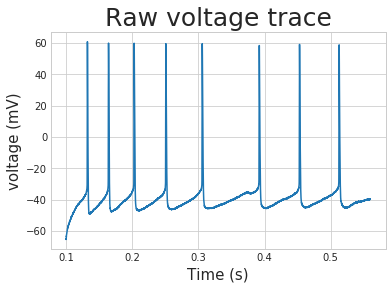

In [272]:
plt.plot(time[ft.find_time_index(time, 0.1)-10:ft.find_time_index(time, 0.5) + 1500], \
         voltage[ft.find_time_index(time, 0.1)-10:ft.find_time_index(time, 0.5) + 1500, 9])
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('voltage (mV)', fontsize = 15)
plt.title('Raw voltage trace', fontsize = 25)
plt.savefig('Weird.png')

In [65]:
dvdt = ft.calculate_dvdt(voltage[:, 15], time)

In [332]:
(1/(1000*(time[1]-time[0])))

20.0

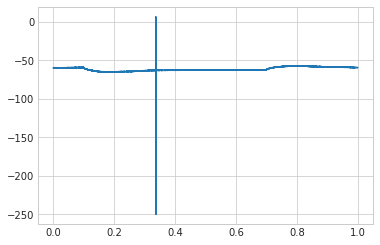

In [74]:
plt.plot(time, voltage[:, 9])

# Analysing spikes

In [330]:
def extract_spike_features(time, current, voltage, start = 0.1, end = 0.7, fil = 10):
    """ Analyse the voltage traces and extract information for every spike (returned in df), and information for all the spikes
    per current stimulus magnitude.

    Parameters
    ----------
    time : numpy 1D array of the time (s)
    current : numpy 1D array of all possible current stimulation magnitudes (pA)
    voltage : numpy ND array of all voltage traces (mV) corresponding to current stimulation magnitudes
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    df : DataFrame with information for every detected spike (peak_v, peak_index, threshold_v, ...)
    df_related_features : DataFrame with information for every possible used current stimulation magnitude
    """
    
    df = pd.DataFrame()
    df_related_features = pd.DataFrame()
    for c, curr in enumerate(current):
        current_array = curr*np.ones_like(time)
        start_index = (np.abs(time - start)).argmin() # Find closest index where the injection current starts
        end_index = (np.abs(time - end)).argmin() # Find closest index where the injection current ends
        current_array[:start_index] = 0
        current_array[end_index:len(current_array)] = 0
        EphysObject = efex.EphysSweepFeatureExtractor(t = time, v = voltage[:, c], i = current_array, start = start, \
                                                      end = end, filter = fil)
        EphysObject.process_spikes()
        #if EphysObject._spikes_df.size:
        #    #Random threshold 15 for now but:
        #    if np.abs(EphysObject._get_baseline_voltage() - np.mean(EphysObject._spikes_df['threshold_v'].values)) < 15:
        #        print('Too steep depolarisation here.')
        #        EphysObject = efex.EphysSweepFeatureExtractor(t = time, v = voltage[:, c], i = current_array, start = 0.1005, \
        #                                                     end = end, filter = fil)
        
        # Adding peak_height (mV) + code for maximum frequency determination (see further)
        spike_count = 0
        if EphysObject._spikes_df.size:
            EphysObject._spikes_df['peak_height'] = EphysObject._spikes_df['peak_v'].values - \
                                                   EphysObject._spikes_df['threshold_v'].values
            spike_count = EphysObject._spikes_df['threshold_i'].values.size
        df = pd.concat([df, EphysObject._spikes_df])

        # Some easily found extra features
        df_features = EphysObject._sweep_features

        # Adding spike count
        df_features.update({'spike_count': spike_count})
        
        # Adding current (pA)
        df_features.update({'current': curr})

        # Adding membrane voltage (mV)
        df_features.update({'resting_membrane_potential': EphysObject._get_baseline_voltage()})

        # Adding voltage deflection (mV)
        voltage_deflection_v, voltage_deflection_i = EphysObject.voltage_deflection()
        df_features.update({'voltage_deflection': voltage_deflection_v})
        
        # Adding input resistance (MOhm)
        # How to calculate the input resistance is not clear yet but this could be an option (although in function
        # get_cell_features it is being calculated differently)
        input_resistance = np.nan
        if not ('peak_i' in EphysObject._spikes_df.keys()) and not curr==0: # We only calculate input resistances 
                                                                            # from traces without peaks
            input_resistance = (np.abs(voltage_deflection_v - EphysObject._get_baseline_voltage())*1000)/np.abs(curr)
            if input_resistance == np.inf:
                input_resistance = np.nan
        df_features.update({'input_resistance': input_resistance})

        # Adding membrane time constant (s) and voltage plateau level for hyperpolarisation paradigms after stimulus onset
        tau = np.nan
        E_plat = np.nan
        # We use hyperpolarising steps as required in the object function to estimate the membrane time constant
        # and E_plateau
        if ft.average_voltage(voltage[:, c], time, start = start, end = end) - \
                  ft.average_voltage(voltage[:, c], time, start = 0, end = start) < -1:
                tau = EphysObject.estimate_time_constant()  # Result in seconds!
                E_plat = ft.average_voltage(voltage[:, c], time, start = end - 0.1, end = end)
        df_features.update({'tau': tau})
        df_features.update({'E_plat': E_plat})


        df_related_features = pd.concat([df_related_features, pd.DataFrame([df_features])])
    
    return df, df_related_features

In [334]:
df, df_related_features = extract_spike_features(time, current, voltage, fil = 7)#1/(2*1000*(time[1]-time[0]))-1)

In [335]:
df

threshold_index  clipped  trough_index  trough_t   trough_v  trough_i  \
0              2493    False          2557   0.12785 -57.776046      40.0   
1              4056    False          4150   0.20750 -56.524806      40.0   
0              2361    False          2426   0.12130 -57.369393      60.0   
1              3164    False          3247   0.16235 -55.961747      60.0   
2              4973    False          5088   0.25440 -55.023317      60.0   
3             12223    False         12388   0.61940 -53.115174      60.0   
0              2285    False          2349   0.11745 -57.744765      80.0   
1              2895    False          2969   0.14845 -56.024309      80.0   
2              3677    False          3764   0.18820 -55.054598      80.0   
3              5077    False          5172   0.25860 -53.678233      80.0   
4             11161    False         11276   0.56380 -52.114182      80.0   
5             13472    False         13579   0.67895 -52.301868      80.0   
0              2228    False          2286   0.11430 -57.682203     100.0   
1              2677    False          2746   0.13730 -55.711499     100.0   
2              3292    False          3372   0.16860 -55.023317     100.0   
3              4168    False          4262   0.21310 -53.365422     100.0   
4              5429    False          5522   0.27610 -52.520835     100.0   
5              9474    False          9589   0.47945 -50.831660     100.0   
6             12384    False         12516   0.62580 -51.300875     100.0   
0              2195    False          2253   0.11265 -57.338112     120.0   
1              2589    False          2660   0.13300 -55.586375     120.0   
2              3065    False          3163   0.15815 -54.522820     120.0   
3              3646    False          3751   0.18755 -53.177736     120.0   
4              4800    False          4897   0.24485 -52.208025     120.0   
5              6568    False          6675   0.33375 -51.676247     120.0   
6             10461    False         10577   0.52885 -49.799386     120.0   
7             11741    False         11893   0.59465 -50.612693     120.0   
0              2171    False          2231   0.11155 -56.994021     140.0   
1              2501    False          2572   0.12860 -54.679225     140.0   
2              2911    False          3000   0.15000 -53.646952     140.0   
..              ...      ...           ...       ...        ...       ...   
33            12858    False         12863   0.64315 -43.887273     340.0   
0              2042    False          2108   0.10540 -53.083893     360.0   
1              2221    False          2292   0.11460 -54.835630     360.0   
2              2417    False          2504   0.12520 -46.827689     360.0   
3              2658    False          2764   0.13820 -45.326200     360.0   
4              2915     True          2961   0.14805  -5.411617     360.0   
5              2962    False          3039   0.15195 -43.855992     360.0   
6              3195    False          3304   0.16520 -46.952813     360.0   
7              3538    False          3670   0.18350 -41.916569     360.0   
8              3952    False          4125   0.20625 -45.044671     360.0   
9              4423    False          4602   0.23010 -41.353510     360.0   
10             4947    False          5117   0.25585 -41.791445     360.0   
11             6627    False          6783   0.33915 -40.727890     360.0   
12             6791    False          6796   0.33980 -56.430963     360.0   
13             7425    False          7430   0.37150 -34.659372     360.0   
14             8100    False          8104   0.40520 -40.383799     360.0   
15             8469    False          8474   0.42370 -33.439412     360.0   
16             8714    False          8720   0.43600 -52.489554     360.0   
17             8788    False          8793   0.43965 -33.095321     360.0   
18             9201    False          9206   0.46030 -40.571485     360.0   


In [336]:
df_related_features

E_plat     adapt  adaptation_index   avg_rate  current  first_isi  \
0 -119.876663       NaN               NaN   0.000000   -200.0        NaN   
0 -111.764712       NaN               NaN   0.000000   -180.0        NaN   
0 -105.640936       NaN               NaN   0.000000   -160.0        NaN   
0  -99.810201       NaN               NaN   0.000000   -140.0        NaN   
0  -94.454467       NaN               NaN   0.000000   -120.0        NaN   
0  -88.224132       NaN               NaN   0.000000   -100.0        NaN   
0  -82.481484       NaN               NaN   0.000000    -80.0        NaN   
0  -74.541141       NaN               NaN   0.000000    -60.0        NaN   
0  -69.120594       NaN               NaN   0.000000    -40.0        NaN   
0  -63.495280       NaN               NaN   0.000000    -20.0        NaN   
0         NaN       NaN               NaN   0.000000      0.0        NaN   
0         NaN       NaN               NaN   0.000000     20.0        NaN   
0         NaN       NaN               NaN   3.333333     40.0    0.07815   
0         NaN  0.492882        225.280199   6.666667     60.0    0.04015   
0         NaN  0.145806        128.196721  10.000000     80.0    0.03050   
0         NaN  0.174544        136.971047  11.666667    100.0    0.02245   
0         NaN  0.100705        120.812183  13.333333    120.0    0.01970   
0         NaN  0.071872        124.242424  16.666667    140.0    0.01650   
0         NaN  0.089574        119.256757  18.333333    160.0    0.01480   
0         NaN  0.083941        122.846442  18.333333    180.0    0.01335   
0         NaN  0.064337        124.050633  18.333333    200.0    0.01185   
0         NaN  0.053882        116.101695  20.000000    220.0    0.01180   
0         NaN  0.087752        120.720721  20.000000    240.0    0.01110   
0         NaN  0.054636        120.000000  18.333333    260.0    0.01050   
0         NaN  0.073822        113.300493  18.333333    280.0    0.01015   
0         NaN  0.112883        119.680851  20.000000    300.0    0.00940   
0         NaN  0.169264        115.675676  16.666667    320.0    0.00925   
0         NaN  0.022292        122.807018  56.666667    340.0    0.00855   
0         NaN  0.016334        109.497207  48.333333    360.0    0.00895   

   input_resistance    isi_cv  latency  mean_isi  median_isi  \
0        314.164385       NaN      NaN       NaN         NaN   
0        308.669107       NaN      NaN       NaN         NaN   
0        302.826759       NaN      NaN       NaN         NaN   
0        315.438363       NaN      NaN       NaN         NaN   
0        312.131280       NaN      NaN       NaN         NaN   
0        307.457875       NaN      NaN       NaN         NaN   
0        318.886556       NaN      NaN       NaN         NaN   
0        313.723360       NaN      NaN       NaN         NaN   
0        328.128533       NaN      NaN       NaN         NaN   
0        360.936080       NaN      NaN       NaN         NaN   
0               NaN       NaN      NaN       NaN         NaN   
0        416.804733       NaN      NaN       NaN         NaN   
0               NaN  0.000000  0.02465  0.078150    0.078150   
0               NaN  0.861478  0.01805  0.164367    0.090450   
0               NaN  0.899900  0.01425  0.111870    0.070000   
0               NaN  0.784384  0.01140  0.084633    0.053425   
0               NaN  0.829289  0.00975  0.068186    0.057700   
0               NaN  0.863636  0.00855  0.062694    0.051650   
0               NaN  0.753483  0.00695  0.057075    0.044000   
0               NaN  0.768719  0.00645  0.054055    0.031800   
0               NaN  1.109921  0.00520  0.050920    0.028150   
0               NaN  1.135405  0.00525  0.051145    0.025200   
0               NaN  0.903399  0.00440  0.049855    0.021900   
0               NaN  1.133141  0.00395  0.049265    0.019100   
0               NaN  1.375720  0.00355  0.048935    0.017375   
0               NaN  1.024730  0.00330  0.045591    0.018950  

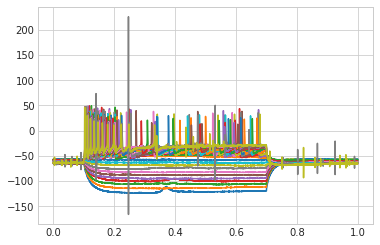

In [337]:
plt.plot(time, voltage)

In [338]:
df_related_features[['E_plat', 'current']].dropna()['current'][-5:]

0   -100.0
0    -80.0
0    -60.0
0    -40.0
0    -20.0
Name: current, dtype: float64

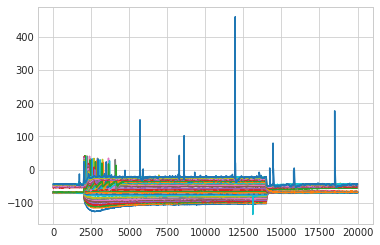

In [320]:
plt.plot(voltage)

In [312]:
def get_cell_features(df, df_related_features):
    """ Analyse all the features available for the cell per spike and per current stimulation magnitude. Extract typical
    features includig the resting membrane potential (Rm, mV), the input resistance (Ri, MOhm), the membrane time constant
    (tau, ms), the action potential threshold (AP threshold, mV), the action potential amplitude (AP amplitude, mV),
    the action potential half-width (AP half-width, ms), the afterhyperpolarisation (AHP, mV), the afterdepolarisation
    (ADP, mV), the adaptation index (AI, %) and the maximum firing frequency (max freq, Hz).
    
    Parameters
    ----------
    df : DataFrame with information for every detected spike
    df_related_features : DataFrame with information for every possible used current stimulation magnitude
    curr_index_0 : integer of current index where the current = 0 pA
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    Returns
    ----------
    Cell_Features : DataFrame with values for all required features mentioned above
    """
    temp_df = df_related_features[['current', 'E_plat']].dropna()
    # The following is based on experimental paradigms where the voltage before stimulation is not necessary the resting
    # membrane potential. The first 5 hyperpolarisation traces below the first trace that shows depolarisation are taken into
    # account. A robust against outliers regression analysis is then performed (does this make sense for only 5 datapoints?) 
 
    ransac = linear_model.RANSACRegressor()
    if (temp_df.shape[0] >= 4):
        ransac.fit(temp_df['current'][-5:].values.reshape(-1, 1), \
                   temp_df['E_plat'][-5:].values.reshape(-1, 1))
        line_X = np.concatenate((temp_df['current'].values, \
                                 np.array([0]))).reshape(-1, 1)
        Ri = ransac.estimator_.coef_[0][0]*1000
        Rm = ransac.predict(np.array([0]).reshape(-1, 1))[0][0]
    else: # Just take as many hyperpolarisation traces available
        ransac.fit(temp_df['current'].values.reshape(-1, 1), \
                   temp_df['E_plat'].values.reshape(-1, 1))
        line_X = np.concatenate((temp_df['current'].values, np.array([0]))).reshape(-1, 1)
        Ri = ransac.estimator_.coef_[0][0]*1000
        Rm = ransac.predict(np.array([0]).reshape(-1, 1))[0][0]
        
    print('Rm: ', Rm)
    print('Ri: ', Ri)
    if (temp_df.shape[0] >= 4):
        plt.plot(temp_df['current'][-5:].values.reshape(-1, 1), \
                   temp_df['E_plat'][-5:].values.reshape(-1, 1), '.m')
    else:
        plt.plot(temp_df['current'].values.reshape(-1, 1), \
                   temp_df['E_plat'].values.reshape(-1, 1), '.m')
    plt.plot(line_X, ransac.predict(line_X))
    plt.legend(['data', 'regression robust to outliers'])
    plt.xlim([-500,  50])
    plt.xlabel('current')
    plt.ylabel('E_plat')
    plt.title('regression analysis')
    
    # We consider all hyperpolarisation traces but perform an average without outliers (outliers are defined as lying above
    # or below 2 standard deviations from the mean)
    tau_array = df_related_features['tau'].dropna().values
    mean = np.mean(tau_array, axis = 0)
    sd = np.std(tau_array, axis = 0)

    tau_array_non_outliers = [x for x in tau_array if (x > mean - 2*sd)]
    tau_array_non_outliers = [x for x in tau_array_non_outliers if (x < mean + 2*sd)]
    tau = np.mean(np.array(tau_array_non_outliers))*1000
    
    if not df.empty:
        max_freq = np.max(df_related_features['spike_count'].values)
        
        non_nan_indexes_AI = ~np.isnan(df_related_features['adaptation_index'].values)
        
        if non_nan_indexes_AI.any():
            AI = np.max(df_related_features['adaptation_index'].values[non_nan_indexes_AI])
        else:
            AI = 0
            
        # First index where there is a spike and the current stimulation magnitude is positive
        index_df = 0
        
        non_nan_indexes_ahp = ~np.isnan(df.loc[0]['fast_trough_v'])
        if non_nan_indexes_ahp.any():
            AHP = df.loc[0]['fast_trough_v'].values[index_df] - df.loc[0]['threshold_v'].values[index_df]
        else:
            AHP = 0
    
        # ADP (after changing a threshold delta_t (i.e. ADP should be shorter in time than this value): by default value set
        # in ephys_features.py from 0.005 to 0.01 !!!!!!!!!!)
        # Calculated w.r.t. AHP index!!!
        non_nan_indexes_adp = ~np.isnan(df.loc[0]['adp_v'])
        if non_nan_indexes_adp.any():
            ADP = df.loc[0]['adp_v'].values[index_df] - df.loc[0]['fast_trough_v'].values[index_df] # Only first peak is considered
            #valid_indexes = ADP_values > 0 # Will also make the Nan's false but we can still
            #          #do np.nanmean in the end
            #ADP = np.nanmean(ADP_values)
        else:
            ADP = 0
        non_nan_indexes_thresh = ~np.isnan(df.loc[0]['threshold_v'])
        if non_nan_indexes_thresh.any():
            if df.loc[0]['threshold_v'].size > 1:
                AP_threshold = df.loc[0]['threshold_v'].values[index_df] # Only first peak is considered
                AP_amplitude = df.loc[0]['peak_height'].values[index_df] # Only first peak is considered
                AP_half_width = 1000*df.loc[0]['width'].values[index_df] # Only first peak is considered
            else:
                AP_threshold = df.loc[0]['threshold_v'] # Only first peak is considered
                AP_amplitude = df.loc[0]['peak_height'] # Only first peak is considered
                AP_half_width = 1000*df.loc[0]['width'] # Only first peak is considered
            
        else:
            AP_threshold = 0
            AP_amplitude = 0
            AP_half_width = 0
    else:
        AHP = 0
        ADP = 0
        max_freq = 0
        AI = 0
        AP_threshold = 0
        AP_amplitude = 0
        AP_half_width = 0
    
    name_features = ['Rm (mV)', 'Input res (MOhm)', 'tau (ms)', 'AP threshold (mV)', 'AP amplitude (mV)', 'AP half-width (ms)', \
                 'AHP (mV)', 'ADP (mV)', 'AI (%)', 'MAX freq']
    features = [Rm, Ri, tau, AP_threshold, AP_amplitude, AP_half_width, AHP, ADP, AI, max_freq]
    cell_features = dict(zip(name_features, features))
    Cell_Features = pd.DataFrame([cell_features])
    Cell_Features = Cell_Features.reindex(columns = name_features)
    return Cell_Features

Rm:  -56.72694805215
Ri:  314.0929709674998


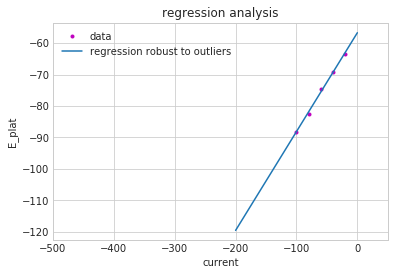

In [339]:
Cell_Features = get_cell_features(df, df_related_features)

In [340]:
Cell_Features

Rm (mV)  Input res (MOhm)   tau (ms)  AP threshold (mV)  \
0 -56.726948        314.092971  23.952863         -43.105247   

   AP amplitude (mV)  AP half-width (ms)   AHP (mV)  ADP (mV)      AI (%)  \
0          92.341575                 0.9 -14.514394         0  225.280199   

   MAX freq  
0        34

In [344]:
def cell_features(data_tuple, data_tuple_suppl_info, names):
    """ Analyses a stream of cell dictionaries and outputs all the cell's features in a concatenated DataFrame
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    All_Cells_Features : DataFrame with values for all required features mentioned in get_cell_features
    """
    All_Cells_Features = pd.DataFrame()
    for (data, data_suppl_info, name) in zip(data_tuple, data_tuple_suppl_info, names):
        print('Processing: ', name)
        time, voltage, current = data_preparation_asc(data, data_suppl_info)
        filter_ = 7
        if (1/(1e3*time[1] - time[0])) <= 11: # Your sampling frequency is not high enough (if filter_ is like 7 though, it 
                                              # should be fine)
            filter_ = 4
            #filter_ = (1/time[1]-time[0])/(1e3*2)-0.5 # You devide by 2 to get half the sampling frequency for the filtering one.
                                                      # Think about the Nyquist theorem
        df, df_related_features = extract_spike_features(time, current, voltage, fil = filter_)
        Cell_Features = get_cell_features(df, df_related_features)
        plt.savefig('../Hippocampus/FiguresRegressionAnalysis/{}.png'.format(name.split('/')[-1].split('.')[0]))
        plt.close()
        All_Cells_Features = pd.concat([All_Cells_Features, Cell_Features])
    All_Cells_Features.insert(0, 'name sample', names)
    return All_Cells_Features.fillna(0)       # Nan values can be considered as 0 for AHP, ADP, ...

In [345]:
All_Cells_Features_HC = cell_features(HC, HC_suppl_info, HC_names)

Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//160828s2c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.24030375000001
Ri:  294.4608125
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170423s3c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.626142500000014
Ri:  282.2561874999999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170509s3c5.asc
Rm:  -52.374174999999994
Ri:  274.13343750000007
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170423s3c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.68377375
Ri:  176.73768750000008
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170509s4c3.asc
Rm:  -74.932164375
Ri:  206.8990625
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170222s1c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -38.96091749999999
Ri:  207.6872500000001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//160828s1c4.asc
Rm:  -66.80107500000001
Ri:  159.84925
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170423s4c5.asc
Rm:  -57.96025750000001
Ri:  580.1120624999999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170917s2c3.asc
Rm:  -60.01760750000001
Ri:  196.30174999999983
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170423s2c7.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -56.60500499999999
Ri:  266.8538750000001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//160828s2c6.asc
Rm:  -59.041115
Ri:  271.3441250000001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170509s4c5.asc
Rm:  -53.649017500000014
Ri:  309.53049999999996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170509s3c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.21139749999999
Ri:  393.83525000000014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170509s2c3.asc
Rm:  -63.63250250000001
Ri:  191.57924999999994
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170423s1c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.88640875
Ri:  127.15668750000006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170423s4c4.asc
Rm:  -67.3862275
Ri:  122.79062499999996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170917s2c6.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.04846500000001
Ri:  144.24862499999995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170222s1c5.asc
Rm:  -50.95478
Ri:  277.70162500000004
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170423s5c5.asc
Rm:  -63.389520000000005
Ri:  217.82131249999995
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170222s2c6.asc
Rm:  -62.070689999999985
Ri:  285.28500000000014
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//160828s1c6.asc
Rm:  -58.638045000000005
Ri:  534.848
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170222s3c4.asc
Rm:  -64.24267250000001
Ri:  222.071
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170509s1c4.asc
Rm:  -60.31976500000002
Ri:  379.88874999999996
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170917s2c5.asc
Rm:  -60.55478625
Ri:  139.1256875
Processing:  ../Hipp

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.5035
Ri:  308.1715000000001
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//160828s3c6.asc
Rm:  -63.078462499999986
Ri:  1.6223214285714604
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170423s5c4.asc
Rm:  -65.68954624999998
Ri:  267.26256250000006
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170917s3c4.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.61269875000002
Ri:  302.3333124999999
Processing:  ../Hippocampus/Hippocampus Data Share with Yves/Xiaolong DATA//170917s3c5.asc


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:944: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


ValueError: attempt to get argmin of an empty sequence

In [342]:
All_Cells_Features_HC.to_csv('../Hippocampus/HippocampusData/Cell_Features_HC_Junzhan.csv')

In [297]:
All_Cells_Features_HC.to_csv('../Hippocampus/HippocampusData/Cell_Features_HC.csv')

# Plotting information as a sanity check

In [ ]:
def plot_info(data, data_suppl_info, start = 0.1, end = 0.7):
    """ Analyses a specific data dictionary corresponding to a cell and returns a figure object with annotations on a particular
    trace of how certain features have been calculated.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    ax : figure object
    """
    time, voltage, current = data_preparation_asc(data, data_suppl_info)    
    filter_ = 7
    if (1/(1e3*time[1] - time[0])) <= 11: # Your sampling frequency is not high at all, so we're forced to change the filter
            filter_ = 4
            #filter_ = (1/time[1]-time[0])/(1e3*2)-0.5 # You devide by 2 to get half the sampling frequency for the filtering one.
                                                      # Think about the Nyquist theorem
    
    df, df_related_features = extract_spike_features(time, current, voltage, fil = filter_)
    Cell_Features = get_cell_features(df, df_related_features)
    
    # First current magnitude (starting from the lowest absolute current stimulation magnitude value) where we find more than
    # three spikes
    current_first = np.flatnonzero(df_related_features['spike_count'].values >=3)[0]
    
    f, ax = plt.subplots(figsize = (10, 10))
    ax.plot(time, voltage[:, current_first])
    
    # Actual current there
    current_first_magn = current[current_first]
    # Amount of spikes there
    spike_count = df_related_features['spike_count'].values[current_first]
    
    
    # Find start and end indexes in df for all the spikes in that particular train
    index_start_df = np.flatnonzero(df['threshold_i'].values >= current_first_magn)[0]
    index_end_df = np.flatnonzero(df['threshold_i'].values >= current_first_magn)[0] + spike_count
    # When last spike is clipped
    if df['clipped'].values[index_end_df-1]:
        index_end_df = np.flatnonzero(df['threshold_i'].values >= \
                                        current_first_magn)[0] + (spike_count - 1)
    # When the spike before the last spike is also clipped
    if df['clipped'].values[index_end_df-1]:
        index_end_df = np.flatnonzero(df['threshold_i'].values >= \
                                        current_first_magn)[0] + (spike_count - 2)
    
    # Get threshold, peak, upstroke and downstroke indexes
    thresh_index = np.array(df['threshold_index'].values[index_start_df : index_end_df], dtype = int)
    upstroke_index = np.array(df['upstroke_index'].values[index_start_df : index_end_df], dtype = int)
    peak_index = np.array(df['peak_index'].values[index_start_df : index_end_df], dtype = int)
    downstroke_index = np.array(df['downstroke_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(df['fast_trough_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(fast_trough_index[~np.isnan(fast_trough_index)], dtype = int)
    slow_trough_index = df['slow_trough_index'].values[index_start_df : index_end_df]
    slow_trough_index = np.array(slow_trough_index[~np.isnan(slow_trough_index)], dtype = int)
    
    start_index = (np.abs(time - start/10)).argmin() # Find closest index where the injection current starts (quite a bit before now)
    end_index = (np.abs(time - end)).argmin() # Find closest index where the injection current ends
    
    ax.plot(time[np.abs(time - start/2).argmin()], Cell_Features['Rm (mV)'], 'C0.', ms = 15)
    ax.plot(time[thresh_index], voltage[thresh_index, current_first], 'b.', ms = 15)
    ax.plot(time[upstroke_index], voltage[upstroke_index, current_first], 'r.', ms = 15)
    ax.plot(time[peak_index], voltage[peak_index, current_first], 'g.', ms = 15)
    ax.plot(time[downstroke_index], voltage[downstroke_index, current_first], 'k.', ms = 15)
    ax.plot(time[fast_trough_index], voltage[fast_trough_index, current_first], 'y.', ms = 15)
    ax.plot(time[slow_trough_index], voltage[slow_trough_index, current_first], 'm.', ms = 15)
    ax.set_xlim([time[start_index], time[end_index]])
    ax.set_xlabel('Time (s)', fontsize = 15)
    ax.set_ylabel('Voltage (mV)', fontsize = 15)
    ax.set_title('Voltage trace in function of time with annotations', fontsize = 25)
    ax.legend(['Trace', 'Resting Vm', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough', \
               'Slow trough (if applicable)'], fontsize = 15, loc='upper left', bbox_to_anchor=(1, 1))
    
    # Nice annotations
    if len(thresh_index) > 2 :
        ax.plot(time[thresh_index[0:3]], voltage[thresh_index[0:3], current_first], '|', color = 'black', ms = 200)
        ax.annotate('', xy = (time[thresh_index[0]], voltage[thresh_index[0], current_first] - 10), \
                xycoords = 'data', xytext = (time[thresh_index[1]], voltage[thresh_index[0], current_first] - 10), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 0.5, 'shrinkA': 0})
        ax.annotate('', xy = (time[thresh_index[1]], voltage[thresh_index[0], current_first] - 10), \
                xycoords = 'data', xytext = (time[thresh_index[2]], voltage[thresh_index[0], current_first] - 10), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 0.5, 'shrinkA': 0})
        plt.annotate('AI = (2e ISI / 1e ISI)*100', xy=(time[thresh_index[1]], voltage[thresh_index[1], current_first]-30), \
                 xycoords='data', xytext=(5, 0), textcoords='offset points', fontsize = 15)
    return ax

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

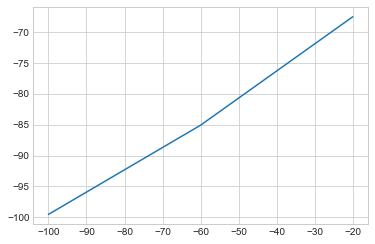

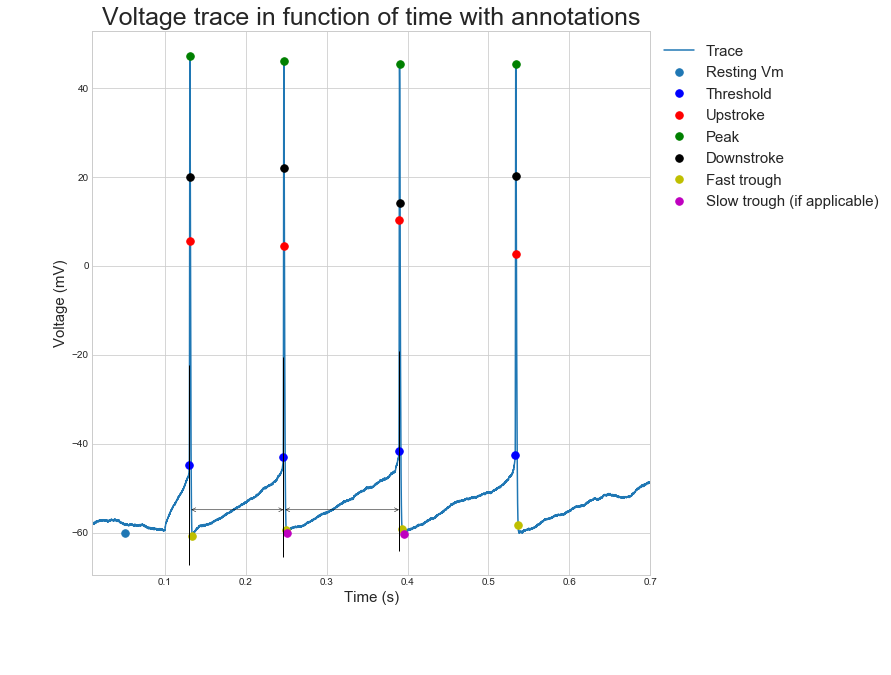

In [257]:
plot_info(HC[0], HC_suppl_info[0])

In [267]:
def plot_info_all(data_tuple, data_tuple_suppl_info, names, directory):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, data_suppl_info, name) in zip(data_tuple, data_tuple_suppl_info, names):
        print('Processing: ', name)
        time, voltage, current = data_preparation(data, data_suppl_info)
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage, fil = filter_)
        if ~np.any(df_related_features['spike_count'] >= 3):         # There might be no traces with more than 3 spikes
                                                                     # whatsoever
            continue
        ax = plot_info(data)
        plt.title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


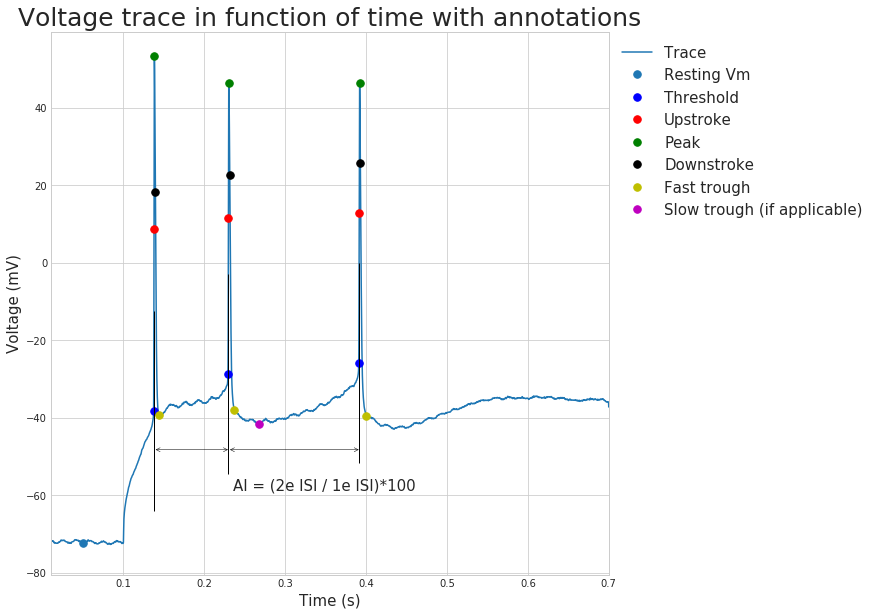

In [356]:
plot_info(data_plot)

In [12]:
directory = '../Hippocampus/Figures_multiple_peaks'
plot_info_all(HC, HC_suppl_info, HC_names, directory)

Processing:  .//06 04 2018 sample 1.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 04 2018 sample 2.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 04 2018 sample 3.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 1.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 05 2018 sample 10.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 05 2018 sample 11.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 12.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 05 2018 sample 13.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 14.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 15.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 16.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 17.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 18.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 19.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 2.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 20.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 3.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 4.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 5.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 05 2018 sample 6.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 7.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 11.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 26 2018 sample 12.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 13.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 26 2018 sample 15.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 16.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 26 2018 sample 17.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 2.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 6.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 26 2018 sample 7.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 8.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 1.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 13.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 3.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 8.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 9.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 11.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 14.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 15.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 2.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 3.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 7.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 05 2018 sample 2.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 05 2018 sample 6.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

In [13]:
def plot_info_first_peak(data, data_suppl_info):
    """ Analyses a specific data dictionary corresponding to a cell and returns a figure object with annotations on the first
    peak of a particular trace of how certain features have been calculated. Works for data extracted from .mat files, not for
    .asc files.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    ax : figure object
    """
    time, voltage, current = data_preparation(data, data_suppl_info)
    filter_ = 7
    if (1/(1e3*(time[1]-time[0]))) < 11: # The sampling frequency is not high at all, so we are forced to change the filter
            filter_ = 5
        df, df_related_features = extract_spike_features(time, current, voltage, fil = filter_)
    Cell_Features = get_cell_features(df, df_related_features)
    current_first = np.flatnonzero(df_related_features['spike_count'].values >=1)[0]


    # Actual current there
    current_first_magn = current[current_first]
    # Amount of spikes there
    spike_count = df_related_features['spike_count'].values[current_first]


    # Find start and end indexes in df for all the spikes in that particular train
    index_start_df = np.flatnonzero(df['threshold_i'].values >= \
    current_first_magn)[0]
    index_end_df = np.flatnonzero(df['threshold_i'].values >= \
    current_first_magn)[0] + spike_count

    # Get threshold, peak, upstroke and downstroke indexes
    thresh_index = np.array(df['threshold_index'].values[index_start_df : index_end_df], dtype = int)
    upstroke_index = np.array(df['upstroke_index'].values[index_start_df : index_end_df], dtype = int)
    peak_index = np.array(df['peak_index'].values[index_start_df : index_end_df], dtype = int)
    downstroke_index = np.array(df['downstroke_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(df['fast_trough_index'].values[index_start_df : index_end_df], dtype = int)
    slow_trough_index = df['slow_trough_index'].values[index_start_df : index_end_df]
    slow_trough_index = np.array(slow_trough_index[~np.isnan(slow_trough_index)], dtype = int)

    
    start_index = thresh_index[0]
    end_index = fast_trough_index[0] + 50 # Plot 50 time indices after the fast trough index (should always exist)
        # When last spike is clipped
    if df['clipped'].values[index_end_df-1]:
        return

    f, ax = plt.subplots(figsize = (10, 10))
    ax.plot(time[start_index : end_index], voltage[start_index : end_index, current_first])

    ax.plot(time[thresh_index[0]], voltage[thresh_index[0], current_first], 'b.', ms = 15)
    ax.plot(time[upstroke_index[0]], voltage[upstroke_index[0], current_first], 'r.', ms = 15)
    ax.plot(time[peak_index[0]], voltage[peak_index[0], current_first], 'g.', ms = 15)
    ax.plot(time[downstroke_index[0]], voltage[downstroke_index[0], current_first], 'k.', ms = 15)
    ax.plot(time[fast_trough_index[0]], voltage[fast_trough_index[0], current_first], 'y.', ms = 15)
    if slow_trough_index.size:
        ax.plot(time[slow_trough_index[0]], voltage[slow_trough_index[0], current_first], 'm.')
        ax.legend(['Trace', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough', 'Slow trough (if applicable)'])
    else:
        ax.legend(['Trace', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough'])
    ax.set_xlabel('Time (s)', fontsize = 15)
    ax.set_ylabel('Voltage (mV)', fontsize = 15)
    ax.set_title('First peak annotations (voltage i.f.o. time)', fontsize = 25)

    # Nice annotations

    ax.annotate('', xy = (time[peak_index[0]], voltage[peak_index[0], current_first]), \
                xycoords = 'data', xytext = (time[peak_index[0]], voltage[thresh_index[0], current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 4, 'shrinkB': 0})
    ax.plot(time[peak_index[0]], voltage[thresh_index[0], current_first], '_', color = 'black', ms = 100)
    ax.plot(time[peak_index[0]], voltage[peak_index[0], current_first], '_', color = 'black', ms = 100)


    width_level = (voltage[peak_index[0], current_first] - voltage[thresh_index[0], current_first])/2 + \
                   voltage[thresh_index[0], current_first]
    width_start_index = peak_index[0] - np.flatnonzero(voltage[peak_index[0] : thresh_index[0]:-1, current_first] <= width_level)[0]
    width_end_index = peak_index[0] + np.flatnonzero(voltage[peak_index[0]: fast_trough_index[0], current_first] <=width_level)[0]
    plt.plot(time[width_start_index], voltage[width_start_index, current_first], '|', color = 'black', ms = 100)
    plt.plot(time[width_end_index], voltage[width_end_index, current_first], '|', color = 'black', ms = 100)

    # The half-width itself is calculated based on t[width_end_index] - t[width_start_index], but the voltages might be different
    # at the respective indices, thus we choose the arrow to go from v[width_start_index] to v[width_start_index] to make
    # it horizontal (interpretability of the figure improves)
    ax.annotate('', xy = (time[width_start_index], voltage[width_start_index, current_first]), \
                xycoords = 'data', xytext = (time[width_end_index], voltage[width_start_index, current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'connectionstyle': 'arc3', 'lw': 4, 'shrinkA': 0})
    ax.annotate('AP half-width', xy = (time[width_start_index], \
                 width_level - 5), xycoords='data', xytext = (5, 0), textcoords = 'offset points', fontsize = 15)

    # For the AP amplitude
    ax.annotate('AP amplitude', xy = (time[peak_index[0]], width_level + 20), \
                 xycoords = 'data', xytext = (5, 0), textcoords = 'offset points', fontsize = 15)
    
    return ax

In [14]:
def plot_info_first_peak_all(data_tuple, data_tuple_suppl_info, names, directory):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, data_suppl_info, name) in zip(data_tuple, data_tuple_suppl_info, names):
        print('Processing: ', name)
        time, voltage, current = data_preparation(data, data_suppl_info)
        filter_ = 7
        if (1/(1e3*(time[1]-time[0]))) < 11: # The sampling frequency is not high at all, so we are forced to change the filter
            filter_ = 5
        df, df_related_features = extract_spike_features(time, current, voltage)
        if ~np.any(df_related_features['spike_count'] >= 1):
            continue
        ax = plot_info_first_peak(data, data_suppl_info)
        plt.title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

In [15]:
directory = '../Hippocampus/Figures_first_peak'
plot_info_first_peak_all(HC, HC_suppl_info, HC_names, directory)

Processing:  .//06 04 2018 sample 1.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 04 2018 sample 2.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 04 2018 sample 3.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 1.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 05 2018 sample 10.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 11.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 12.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 05 2018 sample 13.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 14.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 15.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 16.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 17.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 18.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 19.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 2.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 20.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 05 2018 sample 3.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 4.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 5.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 6.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 05 2018 sample 7.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 11.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 12.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 13.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 15.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 16.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 26 2018 sample 17.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 26 2018 sample 2.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 6.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 26 2018 sample 7.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 26 2018 sample 8.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


Processing:  .//06 27 2018 sample 1.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 13.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 3.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 8.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//06 27 2018 sample 9.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 11.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 14.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 15.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 2.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 3.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 03 2018 sample 7.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 05 2018 sample 2.mat


C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

Processing:  .//07 05 2018 sample 6.mat


C:\Users\Yves\Documents\HoustonRelated\L4\ephys_features.py:945: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by 

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\l

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Yves\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
